In [8]:
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import easysnowdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, mapping
import json
import seaborn as sns

In [2]:
StationsWUS = easysnowdata.automatic_weather_stations.StationCollection()
StationsWUS.get_entire_data_archive()
stations_WUS_da = StationsWUS.entire_data_archive['SNWD'].sel(time=slice('2023-10-01','2024-09-30'))

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Decompressing data...
Creating xarray.Dataset from the uncompressed data...
Done! Entire archive dataset has been added to the station object. Please use the .entire_data_archive attribute to access.


In [9]:
deep_snow_ds = xr.open_dataset('../../data/WUS_tiles/20240320_sd_mosaic-tile-0-mean.tif').squeeze()

In [11]:
deep_snow_ds.band_data.sum()*0.3*(50*50)

<xarray.DataArray 'band_data' ()> Size: 4B
array(2.075485e+11, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B ...
Attributes:
    AREA_OR_POINT:  Area

In [12]:
# errors = []
# perc_errors = []
# features = []

# for station in stations_WUS_da.station.values:
#     geometry = stations_WUS_da.sel(station=station).geometry.values
#     x, y = geometry.item().x, geometry.item().y
#     deep_snow_sd = deep_snow_ds.band_data.sel(x=x, y=y, method='nearest').values
#     snotel_sd = stations_WUS_da.sel(station=station, time=pd.to_datetime('20240405'))
#     error = (snotel_sd - deep_snow_sd).values.item()
#     perc_error = ((error/snotel_sd)*100).item()
#     errors.append(error)
#     perc_errors.append(perc_error)

#     # Create a geojson feature for the station
#     feature = {
#         "type": "Feature",
#         "geometry": mapping(geometry.item()),
#         "properties": {
#             "station_id": station.item(),
#             "deep_snow_sd": deep_snow_sd.item(),
#             "snotel_sd": snotel_sd.item(),
#             "error": error,
#             "perc_error": perc_error
#         }
#     }

#     # Append the feature to the list
#     features.append(feature)

# # Create a geojson feature collection
# geojson = {
#     "type": "FeatureCollection",
#     "features": features
# }

# # Save the geojson to a file
# with open('stations.geojson', 'w') as f:
#     json.dump(geojson, f)

In [4]:
errors = []
perc_errors = []
features = []

for station in stations_WUS_da.station.values:
    geometry = stations_WUS_da.sel(station=station).geometry.values
    x, y = geometry.item().x, geometry.item().y
    
    # Find the indices of the nearest pixel
    nearest_x_idx = deep_snow_ds.x.sel(x=x, method='nearest').x.values
    nearest_y_idx = deep_snow_ds.y.sel(y=y, method='nearest').y.values
    
    # Get the index positions in the dataset
    nearest_x_idx_pos = np.argmin(np.abs(deep_snow_ds.x.values - nearest_x_idx))
    nearest_y_idx_pos = np.argmin(np.abs(deep_snow_ds.y.values - nearest_y_idx))
    
    # Collect snow depth values from the 3x3 area
    median_values = []
    for dx in [-1, 0, 1]:  # Offsets for x
        for dy in [-1, 0, 1]:  # Offsets for y
            x_idx = nearest_x_idx_pos + dx
            y_idx = nearest_y_idx_pos + dy
            # Check if indices are within bounds
            if 0 <= x_idx < len(deep_snow_ds.x) and 0 <= y_idx < len(deep_snow_ds.y):
                sampled_value = deep_snow_ds.band_data.isel(x=x_idx, y=y_idx).values
                median_values.append(sampled_value)
    
    # Calculate the median snow depth
    deep_snow_sd_median = np.median(median_values)
    
    # Retrieve the observed snow depth
    snotel_sd = stations_WUS_da.sel(station=station, time=pd.to_datetime('20240405'))
    
    # Calculate errors
    error = (snotel_sd - deep_snow_sd_median).values.item()
    perc_error = ((error / snotel_sd) * 100).item()
    errors.append(error)
    perc_errors.append(perc_error)

    # Create a GeoJSON feature for the station
    feature = {
        "type": "Feature",
        "geometry": mapping(geometry.item()),
        "properties": {
            "station_id": station.item(),
            "deep_snow_sd_median": deep_snow_sd_median.item(),
            "snotel_sd": snotel_sd.item(),
            "error": error,
            "perc_error": perc_error
        }
    }

    # Append the feature to the list
    features.append(feature)

# Create a GeoJSON feature collection
geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Save the GeoJSON to a file
with open('stations.geojson', 'w') as f:
    json.dump(geojson, f)

In [5]:
np.nanmean(errors)

np.float64(0.22073857078043546)

In [6]:
np.nanstd(errors)

np.float64(0.6333484815097227)

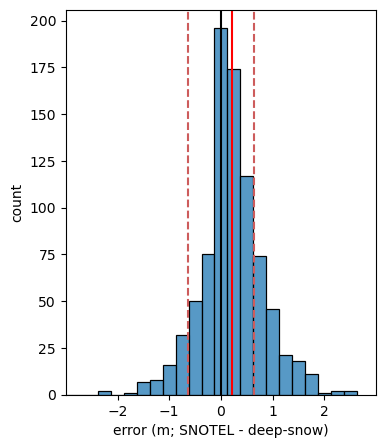

In [7]:
f, ax = plt.subplots(figsize=(4, 5))
sns.histplot(errors, bins=np.arange(-3, 3, 0.25)-0.125)
ax.axvline(0, c='k')
ax.axvline(np.nanmean(errors), c='r')
ax.axvline(np.nanstd(errors), c='indianred', ls='--')
ax.axvline(-np.nanstd(errors), c='indianred', ls='--')
ax.set_xlabel('error (m; SNOTEL - deep-snow)')
ax.set_ylabel('count')
ax.set_xlim(-3, 3)
ax.set_xticks([-2, -1, 0, 1, 2])

#f.savefig('SNOTEL_error.png', dpi=400, bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(3, 4))
sns.histplot(errors, bins=np.arange(-3, 3, 0.25)-0.125)
ax.axvline(0, c='k')
ax.set_xlabel('error (SNOTEL - deep-snow)')
ax.set_ylabel('count')
ax.set_xlim(-3, 3)
ax.set_xticks([-2, -1, 0, 1, 2])

In [10]:
perc_errors = [value for value in perc_errors if value > -100000]

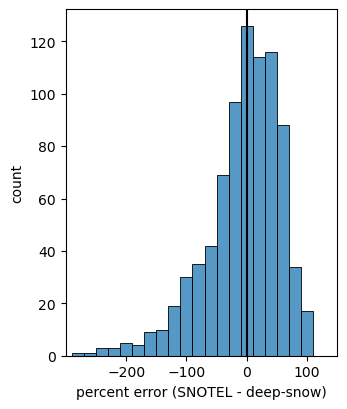

In [11]:
f, ax = plt.subplots(figsize=(3.5, 4.5))
sns.histplot(perc_errors, bins=np.arange(-300, 300, 20)-10)
ax.set_xlim(-300, 150)
ax.axvline(0, c='k')
ax.set_xlabel('percent error (SNOTEL - deep-snow)')
ax.set_ylabel('count')
ax.set_xticks([-200, -100, 0, 100])

In [ ]:
np.nanstd(perc_errors)